# Assigment 8 | Applied Machine Learning | Paras Ahuja

### Please refer to the Assignment 8 dataset. This dataset is composed of two features belonging to certain species. The goal is refining the data about these species such that classes of species and their features can be used to classify the data input from new observations.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np 
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sp
from sklearn.preprocessing import scale
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN, KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score, KFold

In [2]:
og = pd.read_csv("assignment08_dataset.csv")
og.head()

,f1,f2
0,0.494261,1.451067
1,-1.428081,-0.837064
2,0.338559,1.038759
3,0.119001,-1.053976
4,1.122425,1.774937


Let's find out how many rows and columns we have in our dataset.

In [3]:
print("Rows: {}\nColumns: {}".format(og.shape[0], og.shape[1]))

Rows: 750
Columns: 2


We have 750 examples in our dataset, and only two columns. Lets find out some information about the dataset, and see if we have any missing values.

In [4]:
og.isnull().sum()

f1    0
f2    0
dtype: int64

There are no missing values in our dataset. Next we find out some information about the type of data we are dealing with.

In [5]:
og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      750 non-null    float64
 1   f2      750 non-null    float64
dtypes: float64(2)
memory usage: 11.8 KB


Here we notice that the two features have we are of float64 type. We can now begin answering questions.

### 1. How many species must be there in the dataset?

In order to find out how many species we have we can try using a scatter plot and see how the data falls. This will be a simple way to check if there are any patterns, if no patterns exist then we have to look at more advanced techniques. But this is a good first step.

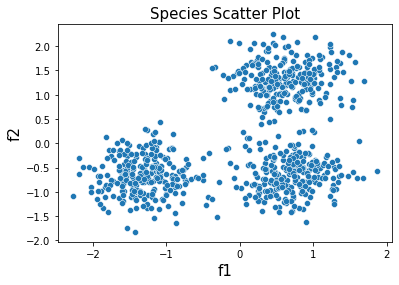

In [6]:
ax = sns.scatterplot(x=og.f1, y=og.f2)

plt.xlabel("f1", fontsize=15)
plt.ylabel("f2", fontsize=15)

plt.title("Species Scatter Plot", fontsize=15)
plt.show()

We notice here that the data naturally clusters. We ca say that there must be 3 species in the dataset because we see three clusters. It is highly likely when we use unpservised learning algorithms, we will also notice this clustering.

### 2. Find the rough feature ranges to classify these species correctly. It might be a good idea to do this step visually from some data plots.

From the scatter plot above we see some ranges, let's approximate these here and then try to find out more specifically. We can label the species as S1, S2, and S3. Here are the ranges we witness from the scatter plot above:

1. S1: Domain(-2.0, -0.7), Range(-1.5, 0.5)
2. S2: Domain(0.0, 1.5), Range(-1.5, 0.0)
3. S3: Domain(0.0, 2.0), Range(0.5, 2.0)

However, this is a very rough estimate, let's try to make this estimate a bit more precise if we can.

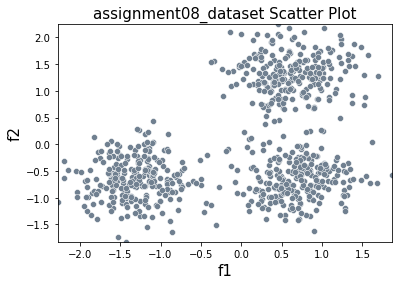

In [7]:
ax = sns.scatterplot(x=og.f1, y=og.f2, color="slategrey")

plt.xlim(og.f1.min(), og.f1.max())
plt.ylim(og.f2.min(), og.f2.max())

plt.xlabel("f1", fontsize=15)
plt.ylabel("f2", fontsize=15)

plt.title("assignment08_dataset Scatter Plot", fontsize=15)
plt.show()

Above we have a bit more refined scatter plot. This shows us a clearer range. We can now refine our earlier estimate of the ranges.

1. S1: Domain(-2.0, -0.7), Range(-1.5, 0.0)
2. S2: Domain(0.0, 1.5), Range(-1.5, 0.0)
3. S3: Domain(0.0, 2.0), Range(0.5, 2.0)

Note: Range is f1, and Domain is f2 for mathematical simplicity.

What we will do here is collect data points from our dataset that match these domain and ranges. But notice that there will be some overlap, so we will have multiple graphs, but this will definitely help us verify if the ranges we have are a good approximation.

In [8]:
s1 = og.loc[og.f1 < -0.7]
s1_s2 = og.loc[og.f2 < 0.5]
s2_s3 = og.loc[og.f1 > -0.7]
s3 = og.loc[og.f2 > 0.5]

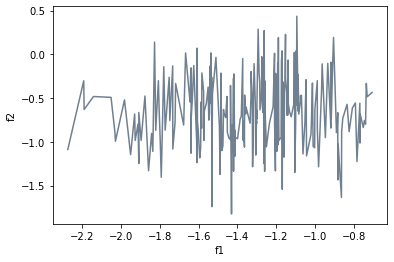

In [9]:
ax = sns.lineplot(data=s1, x=s1.f1, y=s1.f2, color="slategrey")

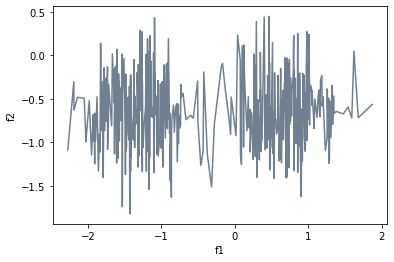

In [10]:
ax = sns.lineplot(data=s1_s2, x=s1_s2.f1, y=s1_s2.f2, color="slategrey")

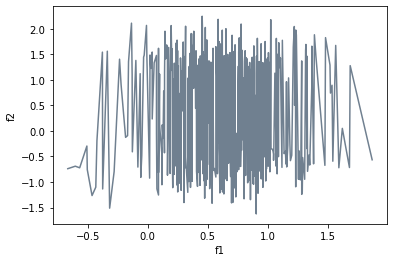

In [11]:
ax = sns.lineplot(data=s2_s3, x=s2_s3.f1, y=s2_s3.f2, color="slategrey")

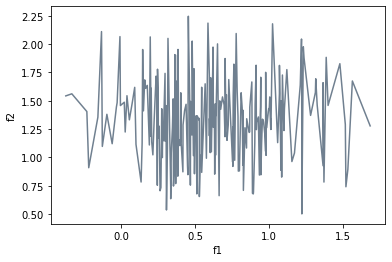

In [12]:
ax = sns.lineplot(data=s3, x=s3.f1, y=s3.f2, color="slategrey")

So finally we can say that we have the following rough ranges: 

1. S1: Domain(-2.0, -0.7), Range(-1.5, 0.0)
2. S2: Domain(0.0, 1.5), Range(-1.5, 0.0)
3. S3: Domain(0.0, 2.0), Range(0.5, 2.0)

### 3. Clean the points that are around the boundaries of the cluster (these points might be due to errors, anomalies, or they are simply outliers). This step is done to refine feature boundaries so that a scientist can classify the species manually, reliably, and with a high generalization. (An example statement, "Species 1 has feature 1 in the range of [0-1.5]")

We need to make sure that we only have the points that fall within our defined range. To make the boundary tighter we will tighten our rough boundary to: 

1. S1: Domain(-2.0, -0.7), Range(-1.5, 0.0)
2. S2: Domain(0.0, 1.2), Range(-1.5, 0.0)
3. S3: Domain(0.0, 2.0), Range(0.5, 2.0)

But realitically we already cleaned the bounds above when we created the s1, s1_s2, s2_s3, and s3 dataframes. What we will do now is modify it even more.

In [13]:
def bound(data, x, y):
    ''' This function takes in domain and range tuple
        and bounds the species of the dataset
    '''
    temp = data.copy()
    
    # Domain
    lower = x[0]
    upper = x[1]    
    
    temp = temp[temp.f1 > lower]
    temp = temp[temp.f1 < upper]
    
    # Range
    lower = y[0]
    upper = y[1]    
    
    temp = temp[temp.f2 > lower]
    temp = temp[temp.f2 < upper]
    
    return temp


In [14]:
s1 = bound(og, (-2, -0.7), (-1.5, 0.0))
s2 = bound(og, (0, 1.2), (-1.5, 0.0))
s3 = bound(og, (0, 2), (0.5, 2.0))

In [15]:
print("Size of species S1: {}\nSize of species S2: {}\nSize of species S3: {}".format(len(s1), len(s2), len(s3)))

Size of species S1: 216
Size of species S2: 209
Size of species S3: 222


In [16]:
species = [s1, s2, s3]
species = pd.concat(species)

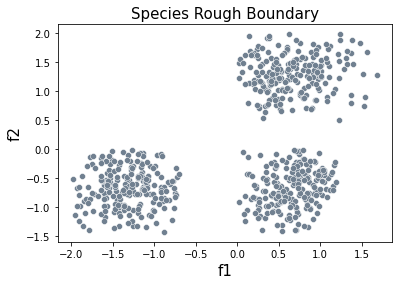

In [17]:
ax = sns.scatterplot(x=species.f1, y=species.f2, color="slategrey")

plt.xlabel("f1", fontsize=15)
plt.ylabel("f2", fontsize=15)

plt.title("Species Rough Boundary", fontsize=15)
plt.show()

In [18]:
s1["Species"] = 0
s2["Species"] = 1
s3["Species"] = 2

df = pd.concat([s1, s2, s3])
df.reset_index(drop=True, inplace=True)
df.head()

,f1,f2,Species
0,-1.428081,-0.837064,0
1,-1.301548,-0.762062,0
2,-1.215782,-0.601021,0
3,-1.250218,-1.057617,0
4,-1.051604,-0.780084,0


### 4. Use K-means clustering to find anomalies (Hint: find cluster data points that are far to the centroid).

We will use distance to measure how far data points are to the centroid.

In [19]:
def distance(f1, f2, center):
    distances = []
    for i in range(len(f1)):
        d = math.sqrt((f1[i] - center[0, 0])**2 + (f2[i] - center[0, 1])**2)
        distances.append(d)
    return distances

First we need to create clusters. We will individually pass each specie to the KMeans algorithm. This means that we will only create 1 cluster. Note that we will seperately calculate the distances for each of the two columns for demonstration purposes. The centers were calculated for the entire species as we can see when the kmeans are calculated.

In [20]:
f1_s1 = np.array(s1.f1)
f2_s1 = np.array(s1.f2)
f1_s2 = np.array(s2.f1)
f2_s2 = np.array(s2.f2)
f1_s3 = np.array(s3.f1)
f2_s3 = np.array(s3.f2)

In [21]:
kmeans_s1 = KMeans(n_clusters = 1).fit(s1)
kmeans_s2 = KMeans(n_clusters = 1).fit(s2)
kmeans_s3 = KMeans(n_clusters = 1).fit(s3)

In [22]:
center_s1 = kmeans_s1.cluster_centers_
center_s2 = kmeans_s2.cluster_centers_
center_s3 = kmeans_s3.cluster_centers_

In [23]:
s1_distances = distance(f1_s1, f2_s1, center_s1)
s2_distances = distance(f1_s2, f2_s2, center_s2)
s3_distances = distance(f1_s3, f2_s3, center_s3)

We now have the distances.

In [24]:
def std_away(array, away=(-1.8, 1.8)):
    zscores = sp.zscore(array)
    new_array = []
    anom_indexes = []
    for i in range(len(array)):
        element = array[i]
        zscore = zscores[i]
        if away[0] <= zscore <= away[1]:
            new_array.append(element)
        else:
            anom_indexes.append(i)
        
    return new_array, anom_indexes

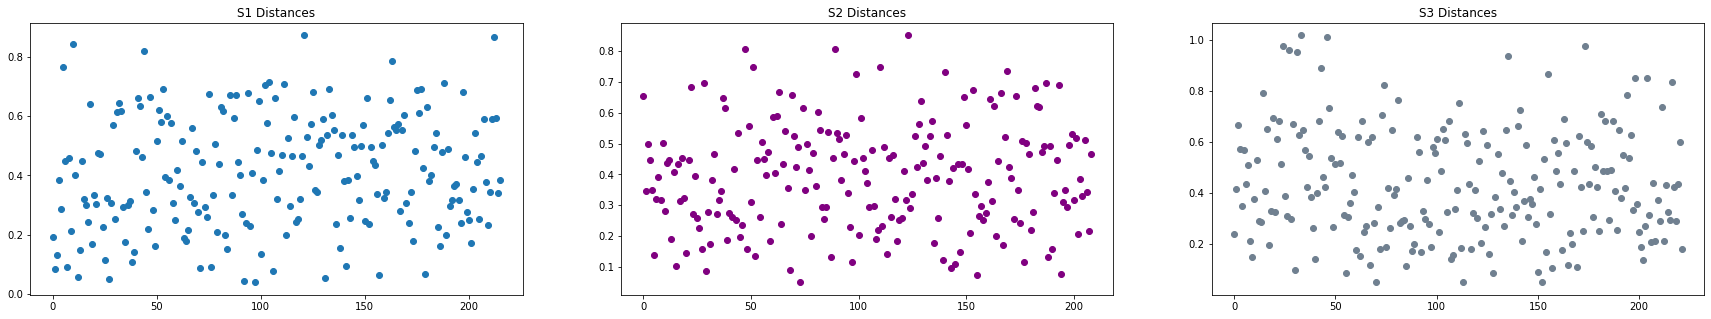

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(30, 5))

axs[0].scatter(range(len(s1_distances)), s1_distances)
axs[0].set_title("S1 Distances")

axs[1].scatter(range(len(s2_distances)), s2_distances, color="purple")
axs[1].set_title("S2 Distances")

axs[2].scatter(range(len(s3_distances)), s3_distances, color="slategrey")
axs[2].set_title("S3 Distances")

plt.show()

We can see that for S1 top 6 points are anomalous as they seem to be quite far from the rest of the points; for S2 we see roughly 7 points at the top. For S3 we only clearly see one point in the top left coner that is not with the rest. Next, we can sort the distances and let say that the last 10-20 distances are what we are interested in as anomalous because they are far from the centroid. However, there is another approach. 

Instead of removing distances without any forethought, we will be removing distances that are not within 1.8 standard deviation of the mean distance. This way there is some statistical thought to our data.  Simply sorting the distances in an ascending order and removing the last $x$ high values will work but how do we know how many values to remove? This method provides some statistical significance.

*Note: I tried removing the values that were not within 1 standard deviation of the mean distance, this resulted in a loss of a lot of the data, and seemed a bit too restrictive. 2 standard deviation was not restrictive enough, I used trial and error and arrived at 1.8 standard deviation.*

In [26]:
s1_distances, indexes_s1 = std_away(s1_distances)
s2_distances, indexes_s2 = std_away(s2_distances)
s3_distances, indexes_s3 = std_away(s3_distances)

Above we have calculated the indexes of these varibles, we will drop these indexes from our dataset in order to have a more closeness in our dataset. But before we do that let's check what our species looks like right now.

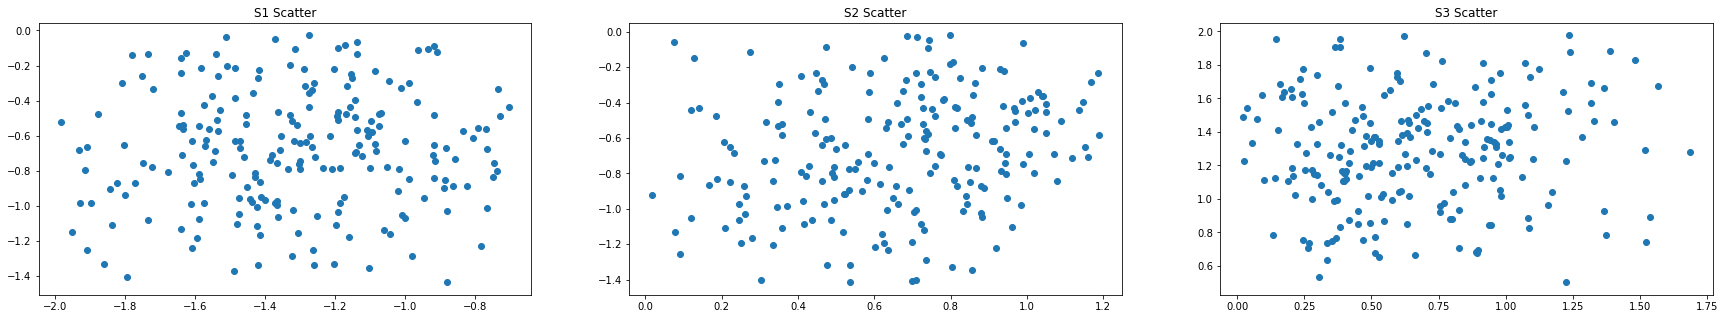

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(30, 5))

axs[0].scatter(s1.f1, s1.f2)
axs[0].set_title("S1 Scatter")

axs[1].scatter(s2.f1, s2.f2)
axs[1].set_title("S2 Scatter")

axs[2].scatter(s3.f1, s3.f2)
axs[2].set_title("S3 Scatter")

plt.show()

In [28]:
anomaly_s1 = s1.iloc[indexes_s1]
anomaly_s2 = s2.iloc[indexes_s2]
anomaly_s3 = s3.iloc[indexes_s3]

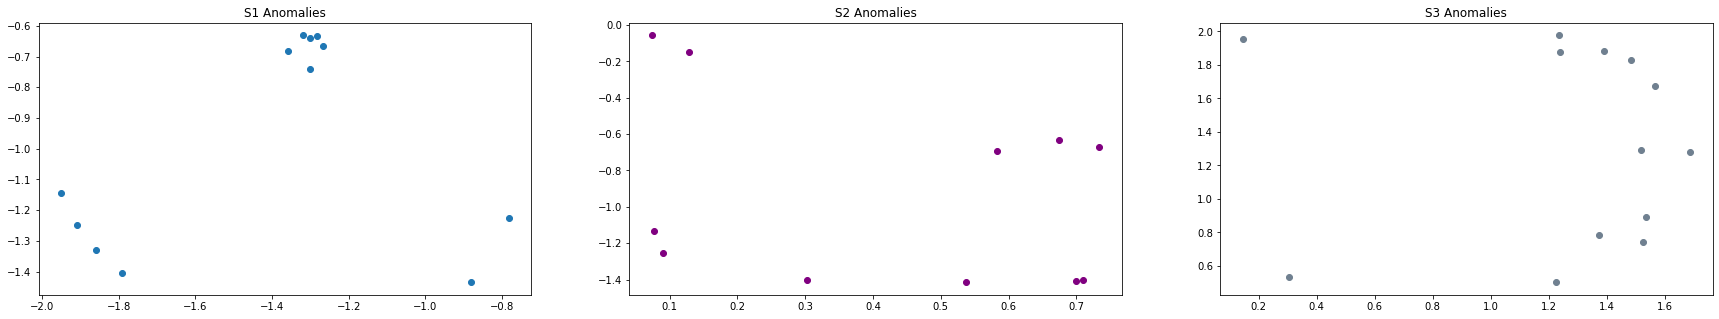

In [29]:
fig, axs = plt.subplots(1, 3, figsize=(30, 5))

axs[0].scatter(anomaly_s1.f1, anomaly_s1.f2)
axs[0].set_title("S1 Anomalies")

axs[1].scatter(anomaly_s2.f1, anomaly_s2.f2, color="purple")
axs[1].set_title("S2 Anomalies")

axs[2].scatter(anomaly_s3.f1, anomaly_s3.f2, color="slategrey")
axs[2].set_title("S3 Anomalies")

plt.show()

Above we have our anomalies from the data. Note that we have used last 20 distaces as anomalies because these have the greatest distance from the centroid. However, we could have always calculated the standard deviation of the data distance and found the values within one standard deviation of the data. However, we notice here that this also a good estimate because we are seeing all the values further away from the centroid. Next we plot our data without these values.

In [30]:
index = np.concatenate((indexes_s1, indexes_s2, indexes_s3))
kmeans_anomalies = df.copy()
kmeans_anomalies = kmeans_anomalies.drop(index=index)

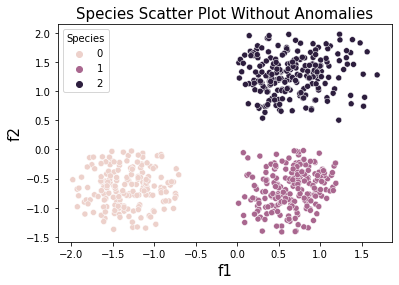

In [31]:
ax = sns.scatterplot(data=kmeans_anomalies, x=kmeans_anomalies.f1, y=kmeans_anomalies.f2, hue="Species")

plt.xlabel("f1", fontsize=15)
plt.ylabel("f2", fontsize=15)

plt.title("Species Scatter Plot Without Anomalies", fontsize=15)
plt.show()

Above we see our data without the anomalies. We removed 20 anomalies from each species - in total we detected 60 anomalies. The remaining points were closer to the centroid than the ones we removed.

In [32]:
km = kmeans_anomalies.copy()

### 5. Use DBSCAN clustering to find anomalies.

We will try a few values for eps as this will definitely yield different results.

In [33]:
dbscan = DBSCAN(eps = 0.1)
predict = dbscan.fit_predict(km)

In [34]:
anom_index = np.where(predict == -1)
values = km.iloc[anom_index]

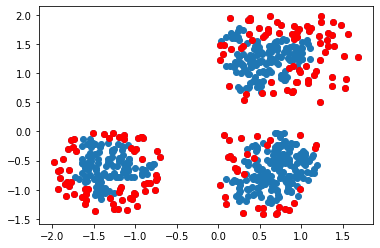

In [35]:
plt.scatter(km.iloc[:,0], km.iloc[:,1])
plt.scatter(values.f1, values.f2, color='r')
plt.show()

In [36]:
print("Anomalies Detected with eps of 0.1: {}".format(len(anom_index[0])))

Anomalies Detected with eps of 0.1: 170


We detected 126 anomalies. However, if we raise the values of eps to 0.2 let's see what happens then.

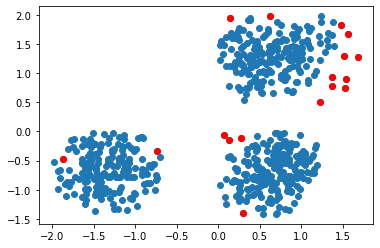

In [37]:
dbscan = DBSCAN(eps = 0.18)
predict = dbscan.fit_predict(km)
anom_index = np.where(predict == -1)
values = km.iloc[anom_index]
plt.scatter(km.iloc[:,0], km.iloc[:,1])
plt.scatter(values.f1, values.f2, color='r')
plt.show()

In [38]:
print("Anomalies Detected with eps of 0.2: {}".format(len(anom_index[0])))

Anomalies Detected with eps of 0.2: 17


Note that EPS represents the maximum distance between two samples for one to be considered as in the neighborhood of the other. However, 0.1 is a bit too restrictive. We will instead use 0.18 instead.

In [39]:
dbscan = DBSCAN(eps = 0.2)
km.reset_index(drop=True, inplace=True)
predict = dbscan.fit_predict(km)
anom_index = np.where(predict == -1)
values = km.iloc[anom_index]

In [40]:
dbs = km.copy()
dbs = dbs.drop(index=anom_index[0])

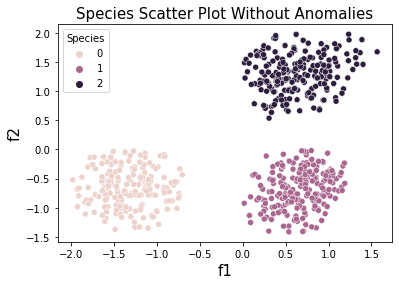

In [41]:
ax = sns.scatterplot(data=dbs, x=dbs.f1, y=dbs.f2, hue="Species")

plt.xlabel("f1", fontsize=15)
plt.ylabel("f2", fontsize=15)

plt.title("Species Scatter Plot Without Anomalies", fontsize=15)
plt.show()

We removed even more anomalies from our dataset, and our data looks much cleaner now than it did before.

### 6. Using the cleaned dataset, develop a decision tree classifier to model the species and show the model decision tree.

In [42]:
dt = DecisionTreeClassifier()
kfold = KFold(n_splits=5)
X = dbs.loc[:, dbs.columns != 'Species']
y = dbs.loc[:, dbs.columns == 'Species']

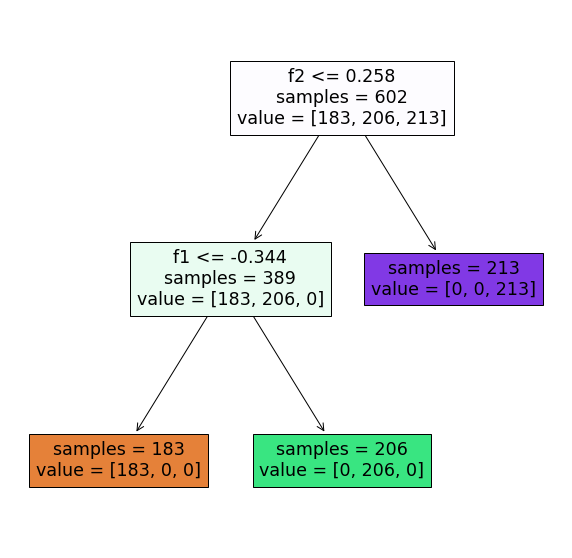

In [43]:
scores = cross_val_score(dt, X, y, cv=kfold, scoring='accuracy')
dt.fit(X, y)
plt.figure(figsize=(10,10))
plot_tree(dt, feature_names=['f1', 'f2'], impurity=False, filled=True)
plt.show()

As we can see above, the decision tree clearly classifies our species. We managed to keep vast majority of the data, still managed to correctly classify.

### 7. Show that, infact, it helped to clean the outliers as above, before generating the decision tree.

#### KMeans

In [44]:
X = np.array(og.copy())

In [45]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

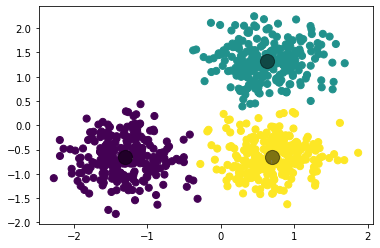

In [46]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

We notice that KMeans was able to classify all the points, however, some points of one cluster are too close to the other cluster and could potentially go either way. We do not know this, and therefore it is best to clean these anomalous points.

In [47]:
dt = DecisionTreeClassifier()
kfold = KFold(n_splits=5)
X = X
y = y_kmeans

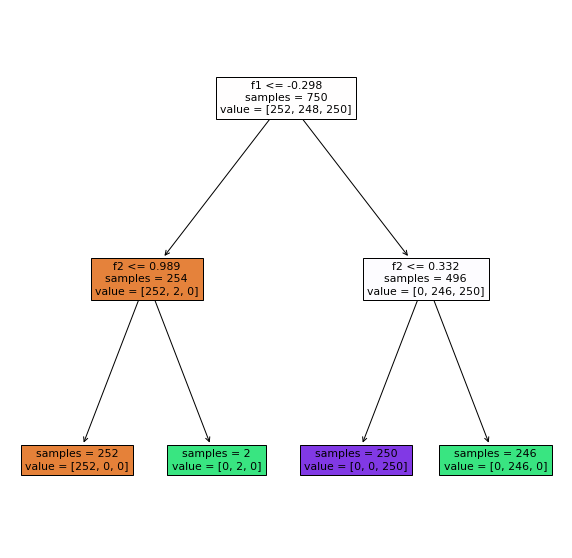

In [48]:
scores = cross_val_score(dt, X, y, cv=kfold, scoring='accuracy')
dt.fit(X, y)
plt.figure(figsize=(10,10))
plot_tree(dt, feature_names=['f1', 'f2'], impurity=False, filled=True)
plt.show()

Using KMeans alone, we were still able to classify our data and we have more number of samples. However, it took us **more number of steps**, than it did earlier. 

#### DBSCAN

In [49]:
X = np.array(og.copy())

In [50]:
dbs = DBSCAN(eps=0.2)
y_dbs = dbs.fit_predict(X)

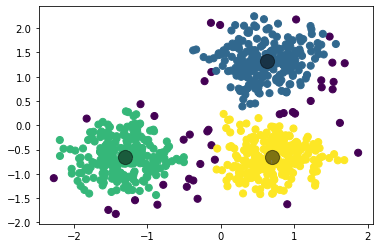

In [51]:
plt.scatter(X[:, 0], X[:, 1], c=y_dbs, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [52]:
dt = DecisionTreeClassifier()
kfold = KFold(n_splits=5)
X = X
y = y_dbs

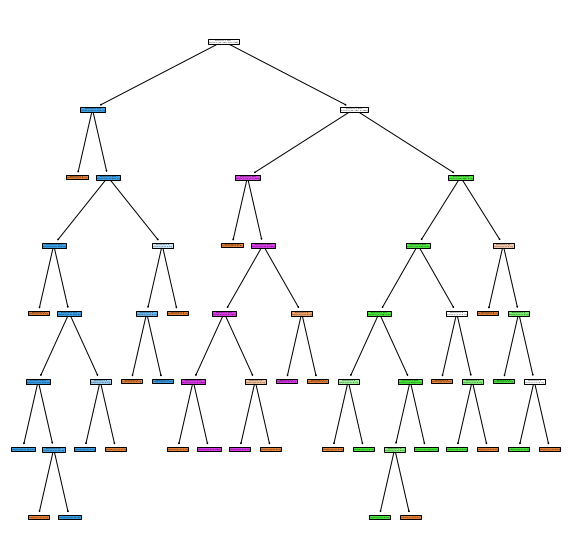

In [53]:
scores = cross_val_score(dt, X, y, cv=kfold, scoring='accuracy')
dt.fit(X, y)
plt.figure(figsize=(10,10))
plot_tree(dt, feature_names=['f1', 'f2'], impurity=False, filled=True)
plt.show()

So we see with DBSCAN our decision tree takes a lot of steps before reaching conclusion. We also notice that with DBSCAN there are points in dark blue that seem anomalous and DBSCAN has not been able to classify these. At this point we can say that it is definitely worth it to use bounding with DBSCAN to arrive at the conclusion much faster.

*Note: I have kept the decision tree size small for demonstration purposes, but if you want to see the tree please increase the size in plt.figure(figsize=(10,10)).*

#### Conclusion

At this point we can understand that cleaning the data points and bounding them was definitely worth the effort. It saved so much time, we classified our data much faster, as can be see by shorted decision trees, we were also able to see clear boundaries of our clusters. However, using bounding and KMeans or bounding and DBSCAN will yield similar, and comparitively efficient results.

#### DBSCAN and Boundary

In [54]:
dbs = df.copy()

In [55]:
dt = DecisionTreeClassifier()
kfold = KFold(n_splits=5)
X = dbs.loc[:, dbs.columns != 'Species']
y = dbs.loc[:, dbs.columns == 'Species']

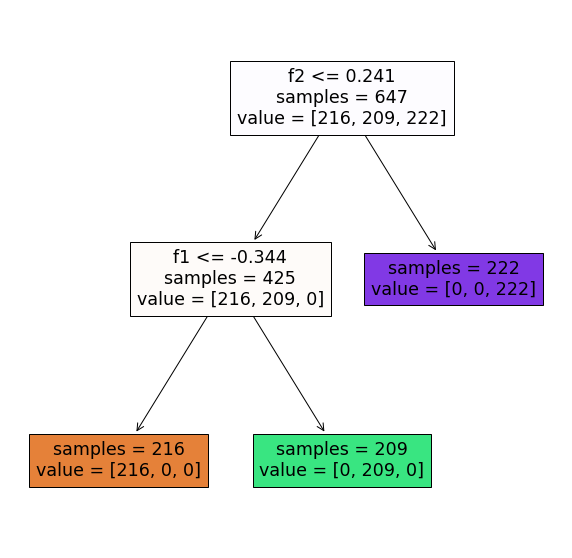

In [56]:
scores = cross_val_score(dt, X, y, cv=kfold, scoring='accuracy')
dt.fit(X, y)
plt.figure(figsize=(10,10))
plot_tree(dt, feature_names=['f1', 'f2'], impurity=False, filled=True)
plt.show()

#### KMeans and Boundary

In [57]:
dt = DecisionTreeClassifier()
kfold = KFold(n_splits=5)
X = km.loc[:, dbs.columns != 'Species']
y = km.loc[:, dbs.columns == 'Species']

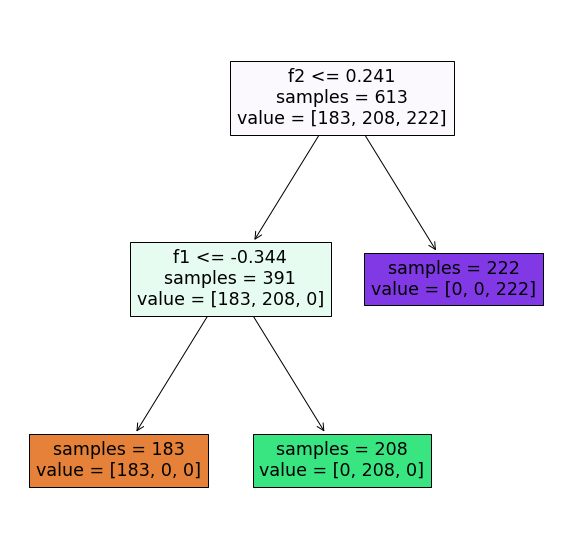

In [58]:
scores = cross_val_score(dt, X, y, cv=kfold, scoring='accuracy')
dt.fit(X, y)
plt.figure(figsize=(10,10))
plot_tree(dt, feature_names=['f1', 'f2'], impurity=False, filled=True)
plt.show()

Thus we conclude that the effort was worth it, however using bounding and either DBSCAN, or KMeans would have provided comparitive results.